# Example multiple model fitting
This notebook shows a basic demonstration of how to run an experiment based on multiple models. We have one response model which is our simulated participant. But we have a number of different models which we will fit. Experimental designs are taken from each of these models randomly on every trial. All model's posteriors over parameters are updated every trial.

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import numpy as np

import darc
from darc.delayed import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC
from dev.darc_parameter_recovery import simulated_multi_experiment
from darc.data_plotting import plot_delay_without_front_end_delays

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 12})

In [4]:
design_thing = BayesianAdaptiveDesignGeneratorDARC(max_trials=16, 
                                  RA=list(np.arange(5, 99+1, 1)), 
                                  DB=list(np.arange(1, 365, 7)))

# create a response model with some true parameters
response_model = models.Hyperbolic(n_particles=5000)
response_model.θ_true = pd.DataFrame.from_dict({'logk': [-4.60], 'α': [2]})

# create a bunch of models to fit
models_to_fit = [models.Exponential(n_particles=5000),
                 models.Hyperbolic(n_particles=5000),
                 models.MyersonHyperboloid(n_particles=5000),
                 models.ModifiedRachlin(n_particles=5000)]

fitted_models, design_thing = simulated_multi_experiment(design_thing, 
                                                         models_to_fit, 
                                                         response_model)

/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:153: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled+n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:226: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled + n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/darc/delayed/models.py:146: RuntimeWarning: overflow encountered in multiply
  VB = data['RB'].values * self._time_discount_func(data['DB'].values, θ['k'].values)
/Users/btvincent/git-local/darc-experiments-python/bad/choice_functions.py:22: RuntimeWarning: overflow encountered in true_divide
  p_chose_B = θ_fixed['ϵ'] + (1 - 2 * θ_fixed['ϵ']) * _Phi(np.divide(decision_variable, α))


trial 0, design from model: 1
trial 1, design from model: 2
trial 2, design from model: 2
trial 3, design from model: 1
trial 4, design from model: 0
trial 5, design from model: 0
trial 6, design from model: 3
trial 7, design from model: 2
trial 8, design from model: 3
trial 9, design from model: 3
trial 10, design from model: 1
trial 11, design from model: 2
trial 12, design from model: 0
trial 13, design from model: 2
trial 14, design from model: 2
trial 15, design from model: 3


Examine the parameter estimates for all of the fitted models

In [5]:
for model in fitted_models:
    print(f'model = {model.__class__.__name__}')
    display(model.get_θ_point_estimate())

model = Exponential


,k,α
0,0.005633,1.823511


model = Hyperbolic


,logk,α
0,-4.720828,1.271164


model = MyersonHyperboloid


,logk,s,α
0,-5.336518,1.561341,0.423135


model = ModifiedRachlin


,logk,s,α
0,-4.742226,1.175585,2.520647


Define plotting functions for visualising posterior predictive discount functions

In [6]:
delays = np.linspace(1, 365, 500)

def exponential_discount_func(delay, k):
    return np.exp(-k * delay)

def exponential_posterior_predictive(ax, fitted_model):
    k = np.median(fitted_model.θ['k'].values)
    y_median = exponential_discount_func(delays, k)
    ax.plot(delays, y_median, label='Exponential', lw=3)
    ax.legend()
    
    
def hyperbolic_discount_func(delay, logk):
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay))

def hyperbolic_posterior_predictive(ax, fitted_model):
    logk = np.median(fitted_model.θ['logk'].values)
    y_median = hyperbolic_discount_func(delays, logk)
    ax.plot(delays, y_median, label='Hyperbolic', lw=3)
    ax.legend()
    
    
def myerson_hyperboloid_discount_func(delay, logk, s):
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay)**s)

def myerson_hyperboloid_posterior_predictive(ax, fitted_model):
    logk = np.median(fitted_model.θ['logk'].values)
    s = np.median(fitted_model.θ['s'].values)
    y_median = myerson_hyperboloid_discount_func(delays, logk, s)
    ax.plot(delays, y_median, label='Hyperboloid', lw=3)
    ax.legend()
    
    
def modified_rachlin_discount_func(delay, logk, s):
    k = np.exp(logk)
    return np.divide(1, (1 + (k * delay)**s))

def modified_rachlin_posterior_predictive(ax, fitted_model):
    logk = np.median(fitted_model.θ['logk'].values)
    s = np.median(fitted_model.θ['s'].values)
    y_median = modified_rachlin_discount_func(delays, logk, s)
    ax.plot(delays, y_median, label='Modified Rachlin', lw=3)
    ax.legend()

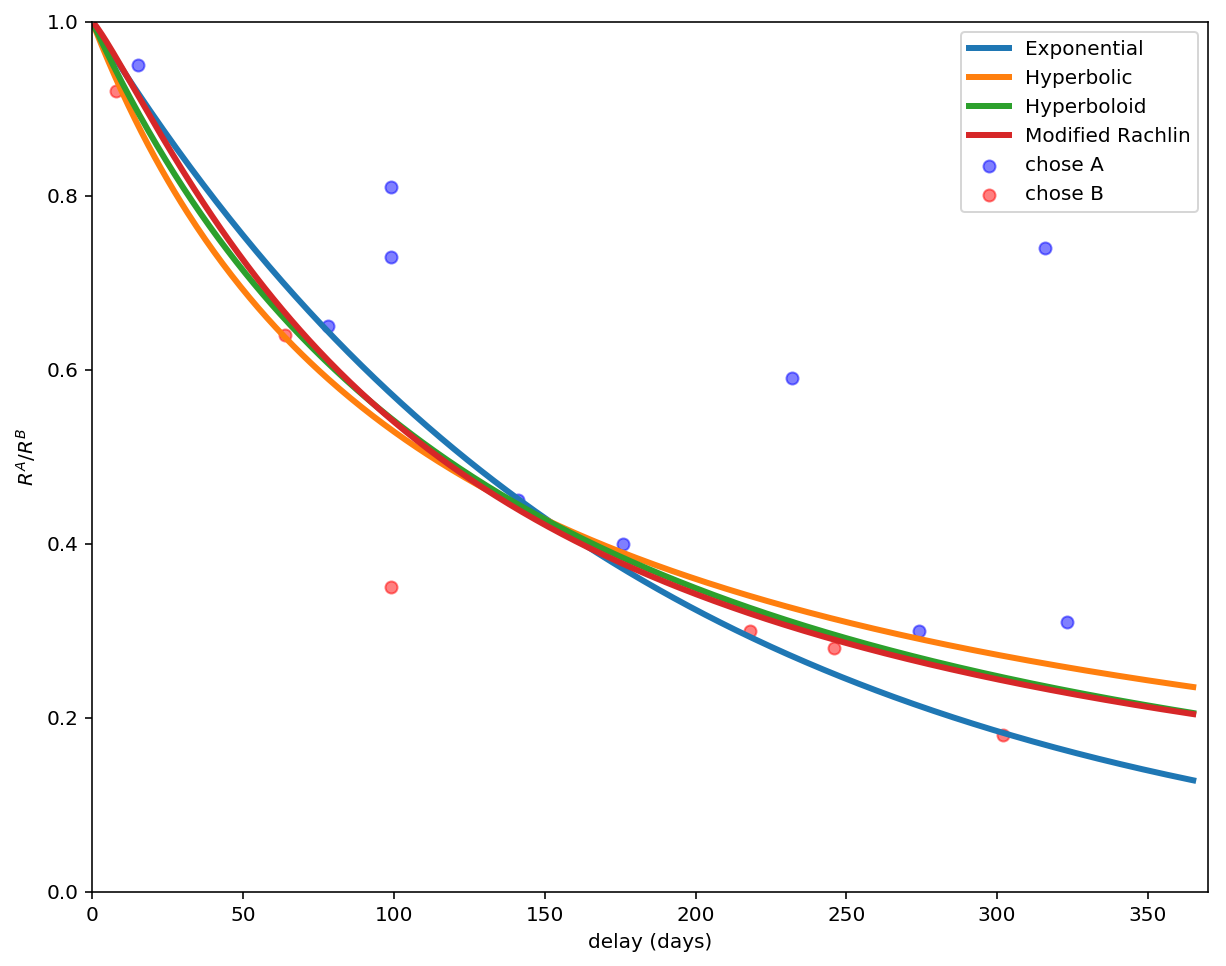

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

# plot data
plot_delay_without_front_end_delays(ax, design_thing.get_df())
ax.set_ylim([0,1])
ax.set_xlim([0,365+5])

# plot discount functions
exponential_posterior_predictive(ax, fitted_models[0])
hyperbolic_posterior_predictive(ax, fitted_models[1])
myerson_hyperboloid_posterior_predictive(ax, fitted_models[2])
modified_rachlin_posterior_predictive(ax, fitted_models[3])

# Testing: calculating model metrics with log likelihood
For AIC and BIC, lower values are better.

In [8]:
def AIC(Lhat, k):
    '''Calculate the AIC metric
    k = number of estimated parameters in the model
    Lhat = maximum of the likelihood function'''
    return 2*k - 2*np.log(Lhat)


def BIC(Lhat, k, n):
    '''Calculate the BIC metric
    k = number of estimated parameters in the model
    n = number of observations
    Lhat = maximum of the likelihood function'''
    return np.log(n)*k - 2*np.log(Lhat)

In [9]:
data = design_thing.data.get_df()

model_name = []
AIC_values = []
BIC_values = []

for model in fitted_models:
    θ = model.θ
    k = model.n_free_parameters
    n = len(data)
    LL = model.log_likelihood(θ, data)
    # calculate max value of likelihood function
    Lhat = np.max(np.exp(LL))
    
    model_name.append(model.__class__.__name__)
    AIC_values.append(AIC(Lhat, k))
    BIC_values.append(BIC(Lhat, k, n))

In [43]:
model_comparison = pd.DataFrame({'model':model_name, 'AIC': AIC_values, 'BIC': BIC_values})

# create new columns corresponding to delta IC measures
model_comparison['ΔAIC'] = model_comparison['AIC']-min(model_comparison['AIC'])
model_comparison['ΔBIC'] = model_comparison['BIC']-min(model_comparison['BIC'])

model_comparison

,model,AIC,BIC,ΔAIC,ΔBIC
0,Exponential,14.238784,15.783961,9.917173,9.917173
1,Hyperbolic,4.321611,5.866788,0.000000,0.000000
2,MyersonHyperboloid,6.321611,8.639377,2.000000,2.772589
3,ModifiedRachlin,9.265101,11.582867,4.943490,5.716079


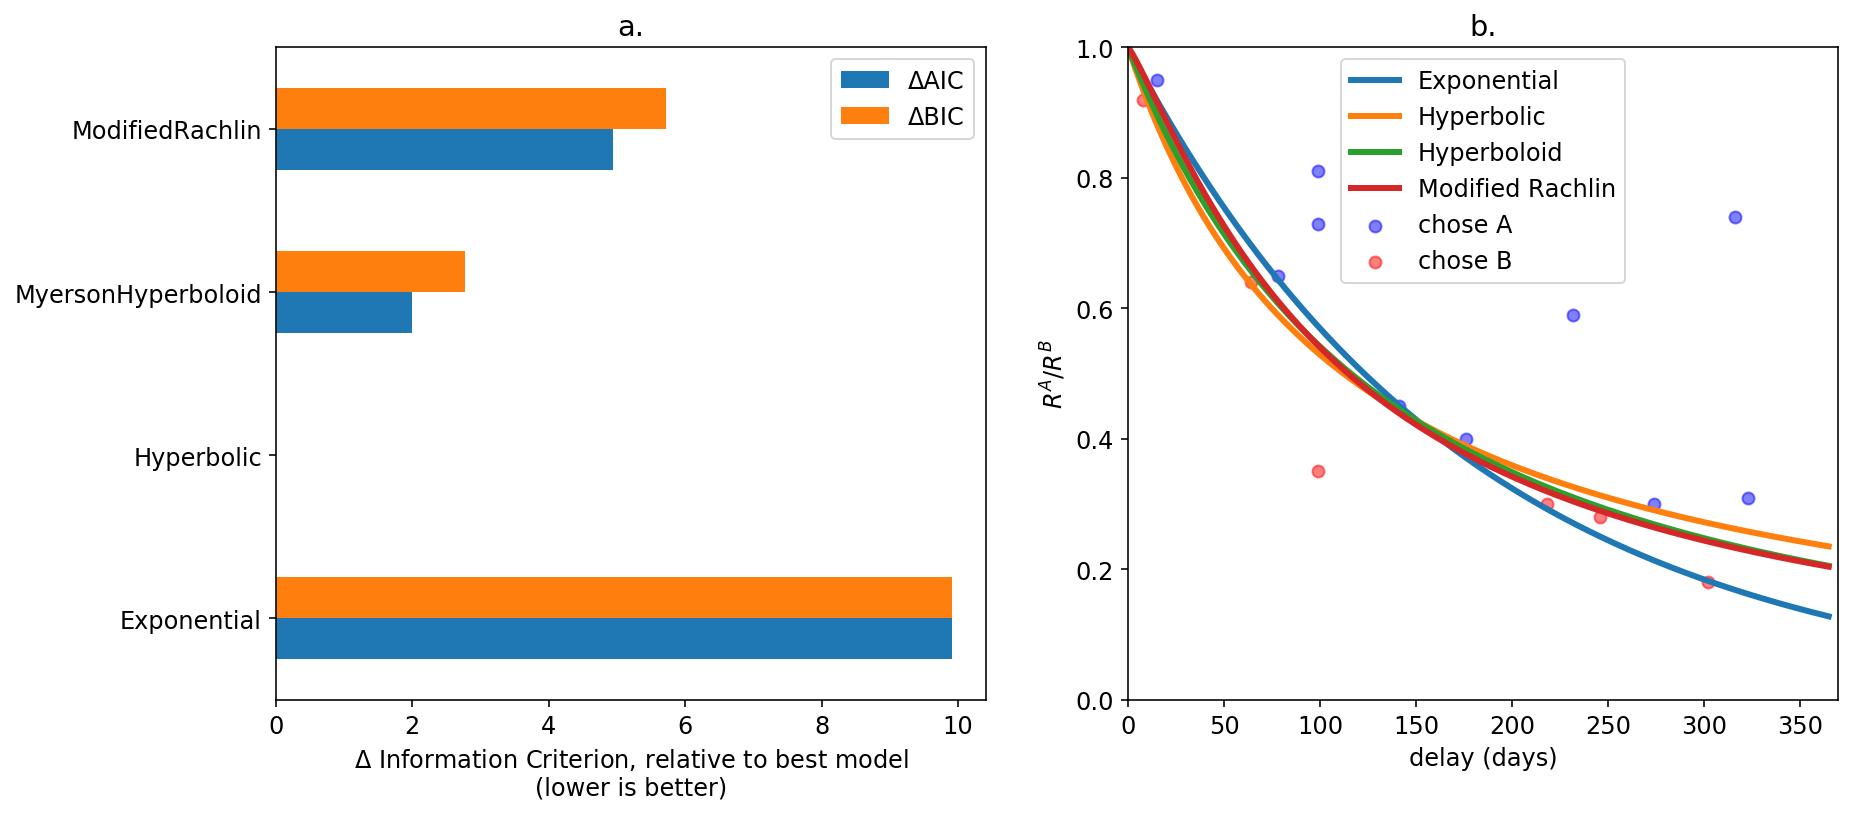

In [44]:
def multiple_model_visulise(ax, fitted_models, design_thing):
    # plot data
    plot_delay_without_front_end_delays(ax, design_thing.get_df())
    ax.set_ylim([0,1])
    ax.set_xlim([0,365+5])
    ax.set_title('b.')

    # plot discount functions
    exponential_posterior_predictive(ax, fitted_models[0])
    hyperbolic_posterior_predictive(ax, fitted_models[1])
    myerson_hyperboloid_posterior_predictive(ax, fitted_models[2])
    modified_rachlin_posterior_predictive(ax, fitted_models[3])

def plot_model_comparison_metrics(ax, fitted_models, design_thing):
    model_comparison[['ΔAIC','ΔBIC']].plot(kind='barh', 
                                         title ='a.',
                                         figsize=(10, 8),
                                         legend=True,
                                         ax=ax)

    ax.set_yticklabels(model_comparison['model'])
    ax.set_xlabel('$\Delta$ Information Criterion, relative to best model\n(lower is better)')



fig, ax = plt.subplots(1, 2)

multiple_model_visulise(ax[1], fitted_models, design_thing)
plot_model_comparison_metrics(ax[0], fitted_models, design_thing)
fig.set_figheight(6)
fig.set_figwidth(14)

fig.savefig('mulitple_model_fitting.pdf', bbox_inches='tight')

In [33]:
Δ